<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/Deep_Learning/Example_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(data_id=40996)

labels_s = '0 T-shirt/top \n1 Trouser \n2 Pullover \n3 Dress \n4 Coat \n5 Sandal \n6 Shirt \n7 Sneaker \n8 Bag \n9 Ankle boot'
fashion_label_translation = {int(k): v for k, v in [item.split(maxsplit=1) for item in labels_s.split('\n')]}

def translate_label(y, translation=fashion_label_translation):
  return pd.Series(y).apply(lambda y: translation[int(y)]).values

def display_fashion(img, target, ax):
  if len(img.shape):
    w = int(np.sqrt(img.shape[0]))
    img = img.reshape((w, w))
  ax.imshow(img, cmap='Greys')
  ax.set_title(f'{target}')
  ax.grid(False)

In [26]:
# Take 10000 images from the dataset and split into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

fashion_mnist_sample = {}
fashion_mnist_sample['data'], _, fashion_mnist_sample['target'], _ = train_test_split(fashion_mnist['data'], fashion_mnist['target'], train_size=10000)

x, y = fashion_mnist_sample['data'], fashion_mnist_sample['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

translation = fashion_label_translation
y_train_translated = translate_label(y_train, translation=translation)
y_test_translated = translate_label(y_test, translation=translation)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_translated)
y_test_encoded = le.transform(y_test_translated)

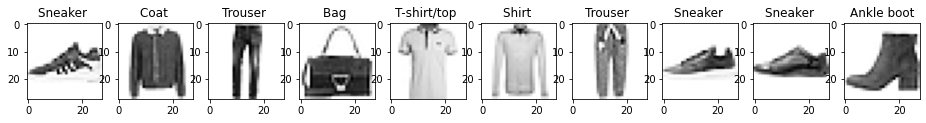

In [25]:
# display the images
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(16,12))
for i in range(10):
  rand = random.choice(range(x_train.shape[0]))
  display_fashion(x_train[rand], y_train_translated[rand], ax=axs[i])
fig.show()

In [27]:
# Training a neural network model
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=500)
clf.fit(x_train, y_train_encoded)
y_test_pred = clf.predict(x_test)

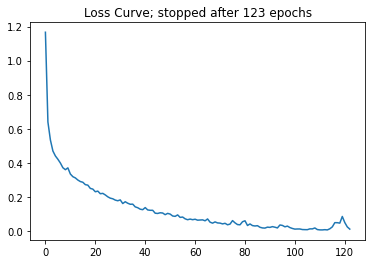

In [28]:
pd.Series(clf.loss_curve_).plot(title=f'Loss Curve; stopped after {clf.n_iter_} epochs')